# Set up

In [1]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

## read data and define test set

In [4]:
data = pd.read_csv("data/filtered_model_data_v2.csv")

In [5]:
data.shape

(3931873, 45)

In [6]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
# n_samples = 100000
# test_data = test_data[:n_samples].copy() ## only take n_samples

In [7]:
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,start_time,time_stamp
232833,34388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680,2018-04-30 17:10:36,1.525108e+09
2731248,240239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,0.283,0.593,1.00,0.429,0.697,NaN,2019-05-08 16:10:36,1.557332e+09
2580858,226837,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN,2021-11-22 21:56:18,1.637618e+09
495987,71768,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN,2020-04-01 15:34:43,1.585755e+09
52737,13191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467,2023-05-29 19:49:48,1.685390e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,64748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.930,0.976,0.213,0.408,0.76,0.394,0.914,1.000,2021-03-10 04:43:37,1.615351e+09
1563518,159550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.167,0.000,NaN,0.100,NaN,0.333,0.378,0.200,2020-12-09 15:36:31,1.607528e+09
2124959,195521,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280,2020-02-04 00:05:07,1.580775e+09
1589803,161130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.296,0.436,0.053,0.754,1.00,0.364,0.432,0.293,2023-06-20 14:39:18,1.687272e+09


In [8]:
# specific sessions to track
# session_id = [3511929, 217809, 4313511, 3694380, 5151980, 3640067, 5313162, 1813788, 4876271, 5025916, 4621927, 2592816, 3673390]
# test_data = test_data.loc[session_id]
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,start_time,time_stamp
232833,34388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680,2018-04-30 17:10:36,1.525108e+09
2731248,240239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,0.283,0.593,1.00,0.429,0.697,NaN,2019-05-08 16:10:36,1.557332e+09
2580858,226837,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN,2021-11-22 21:56:18,1.637618e+09
495987,71768,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN,2020-04-01 15:34:43,1.585755e+09
52737,13191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467,2023-05-29 19:49:48,1.685390e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,64748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.930,0.976,0.213,0.408,0.76,0.394,0.914,1.000,2021-03-10 04:43:37,1.615351e+09
1563518,159550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.167,0.000,NaN,0.100,NaN,0.333,0.378,0.200,2020-12-09 15:36:31,1.607528e+09
2124959,195521,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280,2020-02-04 00:05:07,1.580775e+09
1589803,161130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.296,0.436,0.053,0.754,1.00,0.364,0.432,0.293,2023-06-20 14:39:18,1.687272e+09


In [9]:
test_data[encoding_columns]

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding
232833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2731248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2580858,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
495987,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1563518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2124959,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1589803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
232833,0.371,0.34,NaN,NaN,NaN,0.789,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680
2731248,0.571,0.65,1.000,0.529,0.350,0.768,NaN,NaN,0.275,0.593,1.00,0.429,0.697,NaN
2580858,0.705,0.47,0.911,0.571,0.300,NaN,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN
495987,0.547,0.48,1.000,0.488,0.226,0.013,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN
52737,0.600,0.24,1.000,0.388,0.174,0.327,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.916,0.05,0.845,0.571,0.645,0.947,0.930,0.976,0.213,0.454,0.76,0.394,0.914,1.000
1563518,NaN,NaN,0.466,0.238,0.058,0.105,0.167,0.000,NaN,0.092,NaN,0.333,0.378,0.200
2124959,0.357,0.35,0.370,0.075,0.149,0.373,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280
1589803,0.632,0.00,0.504,0.413,0.194,0.880,0.296,0.436,0.053,0.754,1.00,0.364,0.400,0.293


In [11]:
test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
232833,0.371,0.34,NaN,NaN,NaN,0.789,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680
2731248,0.571,0.65,1.000,0.529,0.350,0.768,NaN,NaN,0.283,0.593,1.00,0.429,0.697,NaN
2580858,0.705,0.47,0.911,0.571,0.300,NaN,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN
495987,0.547,0.48,1.000,0.488,0.232,0.013,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN
52737,0.600,0.24,1.000,0.388,0.174,0.327,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.916,0.05,0.845,0.571,0.645,0.947,0.930,0.976,0.213,0.408,0.76,0.394,0.914,1.000
1563518,NaN,NaN,0.466,0.238,0.058,0.105,0.167,0.000,NaN,0.100,NaN,0.333,0.378,0.200
2124959,0.357,0.35,0.370,0.075,0.149,0.373,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280
1589803,0.632,0.00,0.504,0.413,0.194,0.880,0.296,0.436,0.053,0.754,1.00,0.364,0.432,0.293


## model set up

In [12]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [13]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    print("===== from create_model_data ======")
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    print("data_scores: ", data_scores)
    print("target: ", target)
    return data_scores, target

In [14]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [15]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [16]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

# filter out the non-repeats first for ground truth as the base set

In [17]:
# find whether it is a repeat domain or not
def assign_repeat(df):
    print("================= assign_repeat =============")
    # default to false
    df[repeat_columns] = True
    for idx, row in df.iterrows():
        assignment = True
        # print("the row ", row)
        for encoding_col, score_col in zip(encoding_columns, score_columns):
            # print("columns:" , encoding_col, score_col)
            # Find rows where encoding column is 1
            encoding_is_1 = row[encoding_col] == 1
            
            # Check if the corresponding score column is NaN for those rows
            is_nan = pd.isna(row[score_col])
            # print("encoding is 1 and is nan: ", encoding_is_1, is_nan)
            # Combine the conditions: where encoding column is 1 and score column is NaN
            condition = encoding_is_1 & is_nan
            # print("condition: ", condition)
            if condition:
                assignment = False
                break
            
        # Set the 'repeat' column to True where the condition is met, False otherwise
        # print("assignment: ", assignment)
        df.loc[idx, 'repeat'] = assignment
    # print("after assignment: ", df)
    return df

In [18]:
test_data_assigned  = assign_repeat(test_data)

================= assign_repeat =============


In [19]:
test_data_nonrepeat = test_data_assigned[test_data_assigned.repeat == True].copy()

In [20]:
# make test data copies
ground_truth_test_data = test_data_nonrepeat.copy()
random_test_data = test_data_nonrepeat.copy()
best_test_data = test_data_nonrepeat.copy()

### at this pont, all test data are the same

In [21]:
ground_truth_test_data.shape

(978823, 46)

# create encoding and find prediction

In [22]:
# return prediction given model and input data
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [23]:
# takes in the score columns of the dataframe, return an encoding that chooses randomly from where the nans are so they are non repeats
def create_random_encoding(df):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Create an output array of zeros
    output = np.zeros(df.shape, dtype=int)

    # Iterate over each row
    for i, row in enumerate(~df.isna().values):
        nan_indices = np.where(row)[0]  # Find indices where NaN is present
        if len(nan_indices) > 0:
            chosen_index = np.random.choice(nan_indices)  # Pick one at random
            output[i, chosen_index] = 1  # Set the chosen position to 1
    
    return output

In [24]:
# take in a dataframe, find predictions and return the predictions
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions = predict(model, x_random, torch.from_numpy(y).float())
    return predictions

### random encoding creation and predict performance

In [25]:
# create random encoding
random_encoding = create_random_encoding(random_test_data[score_columns])
random_test_data[encoding_columns] = random_encoding

In [26]:
# find random prediction
random_prediction = find_random_predictions(random_test_data)
random_test_data[target_columns] = random_prediction # change the target columns to the random_prediction values
random_test_data

===== from create_model_data ======
data_scores:  [[0.371 0.629 0.34  ... 0.    0.68  0.32 ]
 [0.571 0.429 0.65  ... 0.303 0.    0.   ]
 [0.705 0.295 0.47  ... 0.    0.    0.   ]
 ...
 [0.357 0.643 0.35  ... 0.73  0.28  0.72 ]
 [0.632 0.368 0.    ... 0.6   0.293 0.707]
 [0.084 0.916 0.65  ... 0.189 1.    1.   ]]
target:  [[0.    0.      nan ... 0.      nan 0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [0.    0.    0.    ...   nan 0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.084 0.    0.    ... 0.    0.      nan]]


,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,start_time,time_stamp,repeat
232833,34388,0,0,0,0,0,0,0,0,0,...,-0.008756,0.002604,0.382386,0.866050,0.004294,-0.000491,-0.000664,2018-04-30 17:10:36,1.525108e+09,True
2731248,240239,0,0,0,1,0,0,0,0,0,...,-0.001115,-0.001615,0.006612,0.001098,-0.003747,-0.004320,0.002337,2019-05-08 16:10:36,1.557332e+09,True
2580858,226837,0,0,0,0,0,0,0,0,0,...,-0.005473,0.048171,0.432796,0.981488,0.003765,0.002638,0.007454,2021-11-22 21:56:18,1.637618e+09,True
495987,71768,0,0,0,0,0,0,0,0,0,...,0.009965,-0.000172,0.013066,0.006043,0.000144,0.925816,0.001314,2020-04-01 15:34:43,1.585755e+09,True
52737,13191,0,0,0,0,1,0,0,0,0,...,0.001621,0.006818,0.001087,-0.007372,-0.004563,-0.004377,0.003261,2023-05-29 19:49:48,1.685390e+09,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,64748,0,1,0,0,0,0,0,0,0,...,-0.000538,0.014717,-0.001281,-0.000120,-0.000878,-0.009592,-0.012449,2021-03-10 04:43:37,1.615351e+09,True
1563518,159550,0,0,0,0,1,0,0,0,0,...,-0.009191,-0.000029,0.001221,-0.003976,-0.001761,0.000731,0.005989,2020-12-09 15:36:31,1.607528e+09,True
2124959,195521,0,0,0,0,0,0,0,0,1,...,0.000106,0.107325,-0.011843,-0.000141,-0.002683,0.000854,0.001984,2020-02-04 00:05:07,1.580775e+09,True
1589803,161130,0,0,0,0,0,1,0,0,0,...,-0.003338,0.001610,-0.012856,0.008911,0.004225,0.009067,-0.010107,2023-06-20 14:39:18,1.687272e+09,True


### best encoding creation and predict perfomrance

In [27]:
# given the number of rows and cols and index, return a numpy array of according size with all 0s except for specified column
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [28]:
# given scores with missing indicators (x) and target (y), return a list of predictions according to which index is 1 in encoding
def predict_all_domains(x, y):
    prediction_list = []
    rows, cols = y.shape
    # loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
    for domain in range(14):
        encoding = create_single_encoding(rows, cols, domain)
        x_single = add_encoding(x, encoding)
        single_prediction = predict(model, x_single, torch.from_numpy(y).float())
        prediction_list.append(single_prediction[:, domain])
    return prediction_list

In [29]:
# given x and y and original dataframe, find the encoding that results in the best scores, return encoding and predictions
def find_best_idx_pred(x, y, original):
    prediction_lst = predict_all_domains(x, y)
    prediction_matrix = np.column_stack(prediction_lst)  # Shape: (100000, 14)
    difference = prediction_matrix - original
    # Find the index of the max difference for each row
    max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
    rows, cols = y.shape
    # Create a zero matrix of shape (100000, 14)
    encoding = np.zeros((rows, cols), dtype=int)
    # Assign 1s at the max_indices positions to create the full encoding matrix with best domains
    encoding[np.arange(rows), max_indices] = 1
    # create a zero matrix of shape (100000, 14)
    predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
    # Fill in the max values at their corresponding positions
    predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
    return encoding, predictions

In [30]:
def max_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = ~np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    max_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    max_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            max_idx = np.argmax(valid_differences)  # Find index of max value (relative to valid_indices)
            max_indices[i] = valid_indices[max_idx]  # Store original column index
            max_values[i] = prediction_matrix[i, valid_indices[max_idx]]  # Get corresponding prediction value

    return max_values, max_indices

In [31]:
def reconstruct_max_matrices(max_values, max_indices, shape):
    max_values_matrix = np.zeros(shape)  # Matrix for max values
    max_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(max_indices[i]):  # Ensure there's a valid index
            col_idx = int(max_indices[i])
            max_values_matrix[i, col_idx] = max_values[i]
            max_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return max_values_matrix, max_indices_matrix

In [32]:
# create best encoding
x_tmp, y_tmp = create_model_data(best_test_data) # create scores with missing indicators and target
rows, cols = y_tmp.shape
prediction_list = []
# loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = add_encoding(x_tmp, encoding)
    print("data put in model", tmp_single)
    single_prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

===== from create_model_data ======
data_scores:  [[0.371 0.629 0.34  ... 0.    0.68  0.32 ]
 [0.571 0.429 0.65  ... 0.303 0.    0.   ]
 [0.705 0.295 0.47  ... 0.    0.    0.   ]
 ...
 [0.357 0.643 0.35  ... 0.73  0.28  0.72 ]
 [0.632 0.368 0.    ... 0.6   0.293 0.707]
 [0.084 0.916 0.65  ... 0.189 1.    1.   ]]
target:  [[0.    0.      nan ... 0.      nan 0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 [0.    0.47  0.    ... 0.    0.      nan]
 ...
 [0.    0.    0.    ...   nan 0.    0.   ]
 [0.    0.    0.    ... 0.    0.432 0.   ]
 [0.    0.    0.    ... 0.    0.      nan]]
============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6800, 0.3200],
        [1.0000, 0.0000, 0.0000,  ..., 0.3030, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..

In [33]:
x_tmp

array([[0.371, 0.629, 0.34 , ..., 0.   , 0.68 , 0.32 ],
       [0.571, 0.429, 0.65 , ..., 0.303, 0.   , 0.   ],
       [0.705, 0.295, 0.47 , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.357, 0.643, 0.35 , ..., 0.73 , 0.28 , 0.72 ],
       [0.632, 0.368, 0.   , ..., 0.6  , 0.293, 0.707],
       [0.084, 0.916, 0.65 , ..., 0.189, 1.   , 1.   ]])

In [34]:
prediction_list

[array([0.3692209 , 0.57507455, 0.73549396, ..., 0.2654758 , 0.5929865 ,
        0.15881027], dtype=float32),
 array([0.3529636 , 0.64036334, 0.52087873, ..., 0.25755557, 0.05834818,
        0.60694283], dtype=float32),
 array([0.7205273 , 0.95419407, 0.8889227 , ..., 0.34316903, 0.49172676,
        0.7812497 ], dtype=float32),
 array([0.5008159 , 0.51492876, 0.5686202 , ..., 0.1156943 , 0.38843852,
        0.71232677], dtype=float32),
 array([0.36931843, 0.3207577 , 0.2949455 , ..., 0.09830678, 0.1892755 ,
        0.19788167], dtype=float32),
 array([0.7386822 , 0.7308262 , 0.526958  , ..., 0.3222808 , 0.80343723,
        0.03842914], dtype=float32),
 array([0.8652821 , 0.46213332, 0.45290652, ..., 0.50684917, 0.33105287,
        0.6752465 ], dtype=float32),
 array([0.554275  , 0.5321377 , 0.61452323, ..., 0.25645062, 0.41382235,
        0.8868118 ], dtype=float32),
 array([0.33466154, 0.30113128, 0.9637834 , ..., 0.10732479, 0.09834021,
        0.39240676], dtype=float32),
 array([0.

In [35]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)
difference = prediction_matrix - np.nan_to_num(best_test_data[score_columns].to_numpy())

# find max indices
max_values, max_indices = max_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
best_predictions, best_encoding = reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

'''
rows, cols = prediction_matrix.shape
# Find the index of the max difference for each row
max_indices = np.argmax(difference, axis=1)  # Shape: (100000,)
# Create a zero matrix of shape (100000, 14)
best_encoding = np.zeros((rows, cols), dtype=int)
# Assign 1s at the max_indices positions to create the full encoding matrix with best domains
best_encoding[np.arange(rows), max_indices] = 1
# create a zero matrix of shape (100000, 14)
best_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type
# Fill in the max values at their corresponding positions
best_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]
'''

'\nrows, cols = prediction_matrix.shape\n# Find the index of the max difference for each row\nmax_indices = np.argmax(difference, axis=1)  # Shape: (100000,)\n# Create a zero matrix of shape (100000, 14)\nbest_encoding = np.zeros((rows, cols), dtype=int)\n# Assign 1s at the max_indices positions to create the full encoding matrix with best domains\nbest_encoding[np.arange(rows), max_indices] = 1\n# create a zero matrix of shape (100000, 14)\nbest_predictions = np.zeros((rows, cols), dtype=prediction_matrix.dtype)  # Keep same data type\n# Fill in the max values at their corresponding positions\nbest_predictions[np.arange(rows), max_indices] = prediction_matrix[np.arange(rows), max_indices]\n'

In [36]:
prediction_matrix

array([[0.3692209 , 0.3529636 , 0.7205273 , ..., 0.3441401 , 0.6437448 ,
        0.674015  ],
       [0.57507455, 0.64036334, 0.95419407, ..., 0.43333453, 0.70261675,
        0.5630632 ],
       [0.73549396, 0.52087873, 0.8889227 , ..., 0.38718283, 0.9707063 ,
        0.56890136],
       ...,
       [0.2654758 , 0.25755557, 0.34316903, ..., 0.38109106, 0.25234884,
        0.28500932],
       [0.5929865 , 0.05834818, 0.49172676, ..., 0.33709747, 0.3942352 ,
        0.32050774],
       [0.15881027, 0.60694283, 0.7812497 , ..., 0.20293523, 0.814448  ,
        0.42630753]], dtype=float32)

In [37]:
ground_truth_test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
232833,0.371,0.34,NaN,NaN,NaN,0.789,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680
2731248,0.571,0.65,1.000,0.529,0.350,0.768,NaN,NaN,0.283,0.593,1.00,0.429,0.697,NaN
2580858,0.705,0.47,0.911,0.571,0.300,NaN,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN
495987,0.547,0.48,1.000,0.488,0.232,0.013,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN
52737,0.600,0.24,1.000,0.388,0.174,0.327,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.916,0.05,0.845,0.571,0.645,0.947,0.930,0.976,0.213,0.408,0.76,0.394,0.914,1.000
1563518,NaN,NaN,0.466,0.238,0.058,0.105,0.167,0.000,NaN,0.100,NaN,0.333,0.378,0.200
2124959,0.357,0.35,0.370,0.075,0.149,0.373,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280
1589803,0.632,0.00,0.504,0.413,0.194,0.880,0.296,0.436,0.053,0.754,1.00,0.364,0.432,0.293


In [38]:
best_test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
232833,0.371,0.34,NaN,NaN,NaN,0.789,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680
2731248,0.571,0.65,1.000,0.529,0.350,0.768,NaN,NaN,0.275,0.593,1.00,0.429,0.697,NaN
2580858,0.705,0.47,0.911,0.571,0.300,NaN,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN
495987,0.547,0.48,1.000,0.488,0.226,0.013,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN
52737,0.600,0.24,1.000,0.388,0.174,0.327,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.916,0.05,0.845,0.571,0.645,0.947,0.930,0.976,0.213,0.454,0.76,0.394,0.914,1.000
1563518,NaN,NaN,0.466,0.238,0.058,0.105,0.167,0.000,NaN,0.092,NaN,0.333,0.378,0.200
2124959,0.357,0.35,0.370,0.075,0.149,0.373,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280
1589803,0.632,0.00,0.504,0.413,0.194,0.880,0.296,0.436,0.053,0.754,1.00,0.364,0.400,0.293


In [39]:
difference

array([[-0.00177909,  0.0129636 ,  0.72052729, ...,  0.02314011,
         0.64374483, -0.00598501],
       [ 0.00407455, -0.00963666, -0.04580593, ...,  0.00433453,
         0.00561675,  0.5630632 ],
       [ 0.03049396,  0.05087873, -0.02207731, ...,  0.00518283,
        -0.02929372,  0.56890136],
       ...,
       [-0.09152419, -0.09244443, -0.02683097, ...,  0.38109106,
        -0.01765116,  0.00500932],
       [-0.03901348,  0.05834818, -0.01227324, ..., -0.02690253,
        -0.00576481,  0.02750774],
       [ 0.07481027, -0.04305717, -0.0337503 , ...,  0.02093523,
         0.003448  ,  0.42630753]])

In [40]:
max_indices

array([10.,  8.,  1., ...,  3.,  1.,  0.])

In [41]:
best_encoding

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [42]:
best_predictions

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.52087873, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05834818, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15881027, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [43]:
best_test_data[encoding_columns] = best_encoding
best_test_data[target_columns] = best_predictions

# separate by repeat vs non repeat

In [44]:
# random assignment
print("ground truth")
ground_truth_test_data_final  = assign_repeat(ground_truth_test_data)
print("random")
random_test_data_final  = assign_repeat(random_test_data)
print("best")
best_test_data_final  = assign_repeat(best_test_data)

ground truth
================= assign_repeat =============
random
================= assign_repeat =============
best
================= assign_repeat =============


# filter depending on number of known domains

In [45]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [46]:
# debug print
def debug_filter_print(df):
    n = df.iloc[0][score_columns].isna().sum()
    total_sessions = df.shape[0]
    print("# of missing = %d, # of total sessions = %d" % (n, total_sessions))
    print(np.isnan(df[score_columns]).sum(axis=1).sum() == n * total_sessions)

In [47]:
ground_truth_test_data_n = dict()
random_test_data_n = dict()
best_test_data_n = dict()

In [48]:
for n in range(1, 14):
    print("======================= filter n missing: n = %d =========================" % n)
    print("============ ground truth ===============")
    tmp = filter_n_missing(ground_truth_test_data_final, n_missing=n)
    ground_truth_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============ random ================")
    tmp = filter_n_missing(random_test_data_final, n_missing=n)
    random_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= best ==================")
    tmp = filter_n_missing(best_test_data_final, n_missing=n)
    best_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

======================= filter n missing: n = 1 =========================
============ ground truth ===============
# of missing = 1, # of total sessions = 215945
True
============ random ================
# of missing = 1, # of total sessions = 215945
True
============= best ==================
# of missing = 1, # of total sessions = 215945
True
======================= filter n missing: n = 2 =========================
============ ground truth ===============
# of missing = 2, # of total sessions = 144999
True
============ random ================
# of missing = 2, # of total sessions = 144999
True
============= best ==================
# of missing = 2, # of total sessions = 144999
True
======================= filter n missing: n = 3 =========================
============ ground truth ===============
# of missing = 3, # of total sessions = 105070
True
============ random ================
# of missing = 3, # of total sessions = 105070
True
============= best ==================
# of missin

In [49]:
ground_truth_test_data_final[score_columns] ## all three should be the same -> current score shouldn't be modified

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
232833,0.371,0.34,NaN,NaN,NaN,0.789,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680
2731248,0.571,0.65,1.000,0.529,0.350,0.768,NaN,NaN,0.275,0.593,1.00,0.429,0.697,NaN
2580858,0.705,0.47,0.911,0.571,0.300,NaN,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN
495987,0.547,0.48,1.000,0.488,0.226,0.013,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN
52737,0.600,0.24,1.000,0.388,0.174,0.327,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.916,0.05,0.845,0.571,0.645,0.947,0.930,0.976,0.213,0.454,0.76,0.394,0.914,1.000
1563518,NaN,NaN,0.466,0.238,0.058,0.105,0.167,0.000,NaN,0.092,NaN,0.333,0.378,0.200
2124959,0.357,0.35,0.370,0.075,0.149,0.373,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280
1589803,0.632,0.00,0.504,0.413,0.194,0.880,0.296,0.436,0.053,0.754,1.00,0.364,0.400,0.293


In [50]:
random_test_data_final[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
232833,0.371,0.34,NaN,NaN,NaN,0.789,0.890,NaN,0.340,0.579,0.84,0.321,NaN,0.680
2731248,0.571,0.65,1.000,0.529,0.350,0.768,NaN,NaN,0.275,0.593,1.00,0.429,0.697,NaN
2580858,0.705,0.47,0.911,0.571,0.300,NaN,NaN,NaN,1.000,0.738,1.00,0.382,1.000,NaN
495987,0.547,0.48,1.000,0.488,0.226,0.013,0.978,1.000,0.160,0.785,0.92,0.533,0.946,NaN
52737,0.600,0.24,1.000,0.388,0.174,0.327,0.370,NaN,0.387,0.592,0.92,0.303,0.757,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454890,0.916,0.05,0.845,0.571,0.645,0.947,0.930,0.976,0.213,0.454,0.76,0.394,0.914,1.000
1563518,NaN,NaN,0.466,0.238,0.058,0.105,0.167,0.000,NaN,0.092,NaN,0.333,0.378,0.200
2124959,0.357,0.35,0.370,0.075,0.149,0.373,NaN,0.329,0.110,0.092,0.80,NaN,0.270,0.280
1589803,0.632,0.00,0.504,0.413,0.194,0.880,0.296,0.436,0.053,0.754,1.00,0.364,0.400,0.293


# score aggregate

In [51]:
def overall_avg_improvement_with_std(df):
    pred_score = df[target_columns].to_numpy()
    cur_score = df[score_columns].to_numpy()
    encoding = df[encoding_columns].to_numpy()

    print("prediction score: ", pred_score)
    print("current score: ", cur_score)
    print("encoding: ", encoding)

    pred_score = np.nan_to_num(pred_score, nan=0) * encoding
    cur_score = np.nan_to_num(cur_score, nan=0) * encoding
    assert pred_score.shape == cur_score.shape and cur_score.shape == encoding.shape

    # Compute improvement
    improvement = encoding * (pred_score - cur_score)

    # Extract nonzero values
    nonzero_improvement = improvement[improvement != 0]

    if len(nonzero_improvement) == 0:
        avg_improvement = 0
        std_dev = 0
        print("No sessions with nonzero improvement")
    else:
        avg_improvement = np.mean(nonzero_improvement)
        std_dev = np.std(nonzero_improvement, ddof=1)  # Using sample standard deviation (ddof=1)

        print("Number of predicted domains:", len(nonzero_improvement))
        print("Average improvement:", avg_improvement)
        print("Standard deviation:", std_dev)

    return avg_improvement, std_dev

In [52]:
nonrepeat_ground_truth_avg = []
nonrepeat_random_avg = []
nonrepeat_best_avg = []

nonrepeat_ground_truth_std = []
nonrepeat_random_std = []
nonrepeat_best_std = []

In [53]:
for n in range(1, 14):
    print("========= %d missing" % n)
    print("----ground truth----")
    # ground truth
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    if len(temp_nonrepeat) != 0:
        nonrepeat_ground_truth_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_ground_truth_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_ground_truth_avg.append(0)
        nonrepeat_ground_truth_std.append(0)

    print("----random----")
    # random
    temp_nonrepeat = random_test_data_n[n][random_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_random_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_random_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_random_avg.append(0)
        nonrepeat_random_std.append(0)
    
    print("----best----")
    # best
    temp_nonrepeat = best_test_data_n[n][best_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_best_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_best_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_best_avg.append(0)
        nonrepeat_best_std.append(0)

========= 1 missing
----ground truth----
prediction score:  [[0.547 0.48  1.    ... 0.533 0.946   nan]
 [0.6   0.24  1.    ... 0.303 0.757 0.467]
 [0.905 1.    1.    ... 0.461 0.908 1.   ]
 ...
 [0.357 0.47    nan ... 0.229 0.679 0.167]
 [0.357 0.13  0.733 ... 0.333 0.8   0.513]
 [0.084 0.65  0.815 ... 0.182 0.811   nan]]
current score:  [[0.547 0.48  1.    ... 0.533 0.946   nan]
 [0.6   0.24  1.    ... 0.303 0.757 0.467]
 [0.905 1.    1.    ... 0.461 0.908 1.   ]
 ...
 [0.357 0.47    nan ... 0.229 0.679 0.167]
 [0.357 0.13  0.733 ... 0.333 0.8   0.513]
 [0.084 0.65  0.815 ... 0.182 0.811   nan]]
encoding:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of predicted domains: 79365
Average improvement: 0.0021311157311157316
Standard deviation: 0.06970720403777973
prediction score:  [[0.547 0.48  1.    ... 0.533 0.946   nan]
 [0.6   0.24  1.    ... 0.303 0.757 0.467]
 [0.90

# Prediction accuracy using ground truth data

In [54]:
def plot_error_by_nan_count_nonzero_only(prediction_matrix, ground_truth_df, metric="mae"):
    """
    Plots error per number of NaNs in score columns with error bars, considering only nonzero values.

    Parameters:
    prediction_matrix (np.ndarray): 2D NumPy array of predicted values.
    ground_truth_df (pd.DataFrame): DataFrame containing ground truth and score columns.
    metric (str): "mae" for Mean Absolute Error, "mse" for Mean Squared Error.
    """
    global score_columns  # List of score column names
    global target_columns  # List of target columns
    global encoding_columns  # List of encoding columns

    # new_df = pd.DataFrame(data=)

    mean_errors_list = []
    ground_truth_std_list = []
    nan_counts = list(range(1, 14))  # Checking sessions with 1 to 13 NaNs
    ground_truth_dict = dict()
    mean_data = []

    for n in nan_counts:
        print("n == ", n)
        filtered_df = filter_n_missing(ground_truth_df, n)  # Filter by NaN count
        
        if filtered_df.empty:  # Skip if no data
            assert(True)
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        # Correctly map DataFrame indices to NumPy indices
        valid_indices = ground_truth_df.index.get_indexer(filtered_df.index)
        valid_indices = valid_indices[valid_indices >= 0]  # Ensure only valid indices are used
        print("valid indices: ", valid_indices)
        # Extract matrices
        ground_truth_matrix = np.nan_to_num(filtered_df[target_columns].to_numpy()[filtered_df[encoding_columns].to_numpy() == 1])
        filtered_prediction_matrix = prediction_matrix[valid_indices][filtered_df[encoding_columns].to_numpy() == 1]

        # Ensure matrices have the same shape
        assert filtered_prediction_matrix.shape == ground_truth_matrix.shape, "Mismatch in matrix shapes"
        print("ground truth: ", ground_truth_matrix)
        print("prediction: ", filtered_prediction_matrix)
        # Compute improvement (errors)
        errors = np.abs(filtered_prediction_matrix - ground_truth_matrix) if metric == "mae" else (filtered_prediction_matrix - ground_truth_matrix) ** 2

        # print("Shape of filtered_df for n = %d: %d" % (n, filtered_df.shape[0]))
        # Extract only nonzero errors
        nonzero_errors = errors
        nonzero_ground_truth = ground_truth_matrix

        ground_truth_dict[str(n)] = nonzero_ground_truth

        # print("number of domainss known total (might be more than number of sessions)", filtered_df[encoding_columns].to_numpy().sum())
        print("zero_error: ", nonzero_errors)
        # print("shape of nonzero_ground_truth: ", nonzero_ground_truth.shape)
        print("mae output with code from next_step.py: ", np.mean(np.abs(filtered_prediction_matrix - ground_truth_matrix)))

        if len(nonzero_errors) == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            mean_data.append(np.nan)
        else:
            mean_errors_list.append(np.mean(nonzero_errors))
            ground_truth_std_list.append(np.std(nonzero_ground_truth, ddof=1))  # Sample standard deviation
            mean_data.append(np.mean(nonzero_ground_truth))

    # Convert to numpy arrays
    mean_errors = np.array(mean_errors_list)
    error_std = np.array(ground_truth_std_list)
    # convert dictionary to dataframe for plotting
    plot_df = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df, ax=axes)
    # axes.plot(plot_df.keys(), mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data - mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data + mean_errors, color="cyan")
    axes.plot(plot_df.keys(), mean_data, label="Ground Truth Mean", marker="x", color="red", linewidth=2)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Error")
    plt.title(f"Ground Truth Distribution and Average Prediction")
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()


    plt.figure()
    plt.plot(nan_counts, error_std, label="ground truth std", marker="x")
    plt.plot(nan_counts, mean_errors, label="Prediction MAE", marker="o")
    # plt.errorbar(nan_counts, mean_errors, yerr=error_std, fmt='-o', capsize=5, color='b', alpha=0.7)
    plt.xticks(nan_counts)
    plt.ylim(-np.nanmax(error_std) * 1.1, np.nanmax(mean_errors + error_std) * 1.1 if not np.isnan(np.nanmax(mean_errors)) else 1)

    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Error")
    plt.title(f"Prediction {metric.upper()} and Ground Truth Std. Comparison")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.show()


In [55]:
x_tmp, y_tmp = create_model_data(ground_truth_test_data_final) # create scores with missing indicators and target
rows, cols = y_tmp.shape
encoding = ground_truth_test_data_final[encoding_columns].to_numpy()
print("encoding: ", encoding)
x_train_tmp = add_encoding(x_tmp, encoding)
print("data put in model", x_train_tmp)
ground_truth_prediction = predict(model, x_train_tmp, torch.from_numpy(y_tmp).float())

===== from create_model_data ======
data_scores:  [[0.371 0.629 0.34  ... 0.    0.68  0.32 ]
 [0.571 0.429 0.65  ... 0.303 0.    0.   ]
 [0.705 0.295 0.47  ... 0.    0.    0.   ]
 ...
 [0.357 0.643 0.35  ... 0.73  0.28  0.72 ]
 [0.632 0.368 0.    ... 0.6   0.293 0.707]
 [0.084 0.916 0.65  ... 0.189 1.    1.   ]]
target:  [[0.    0.      nan ... 0.      nan 0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 [0.    0.47  0.    ... 0.    0.      nan]
 ...
 [0.    0.    0.    ...   nan 0.    0.   ]
 [0.    0.    0.    ... 0.    0.432 0.   ]
 [0.    0.    0.    ... 0.    0.      nan]]
encoding:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
data put in model tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6800, 0.3200],
        [0.0000, 0.0000, 0.0000,  ..., 0.3030, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000

# Visualizations

## prediction accuracy

n ==  1
valid indices:  [     3      4      6 ... 978807 978812 978822]
ground truth:  [0.232 0.467 0.722 ... 0.679 0.031 0.662]
prediction:  [0.24401829 0.4629679  0.7382671  ... 0.6581768  0.09213179 0.6481005 ]
zero_error:  [0.01201829 0.0040321  0.01626712 ... 0.02082322 0.06113179 0.0138995 ]
mae output with code from next_step.py:  0.030157296279258828
n ==  2
valid indices:  [     8     16     19 ... 978787 978811 978820]
ground truth:  [0.8   0.5   0.275 ... 0.56  0.695 0.373]
prediction:  [0.7805872  0.44888768 0.10211837 ... 0.5543774  0.7126257  0.3222808 ]
zero_error:  [0.0194128  0.05111232 0.17288163 ... 0.00562262 0.01762568 0.05071921]
mae output with code from next_step.py:  0.03085367123951605
n ==  3
valid indices:  [     1     15     21 ... 978798 978801 978816]
ground truth:  [0.283 0.83  0.303 ... 0.279 0.7   0.369]
prediction:  [0.30113128 0.7333026  0.31864738 ... 0.27576753 0.68856406 0.35477698]
zero_error:  [0.01813128 0.09669741 0.01564738 ... 0.00323247 0.0

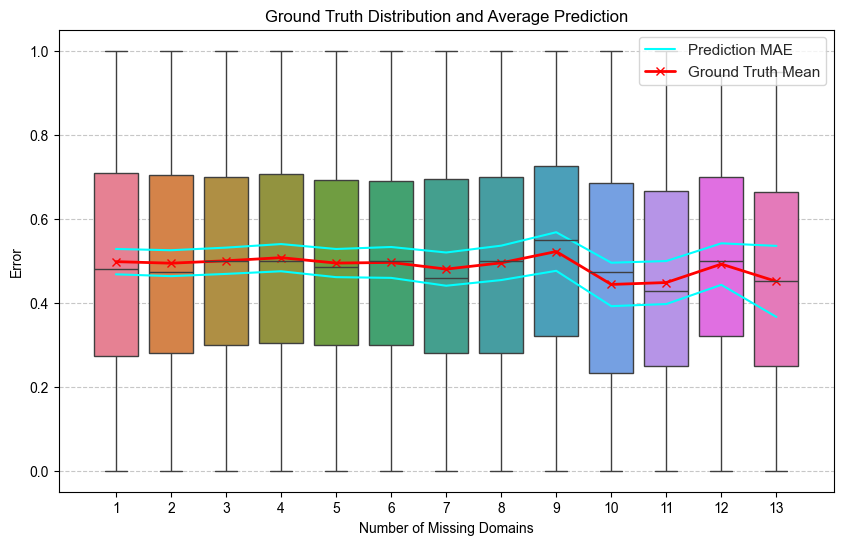

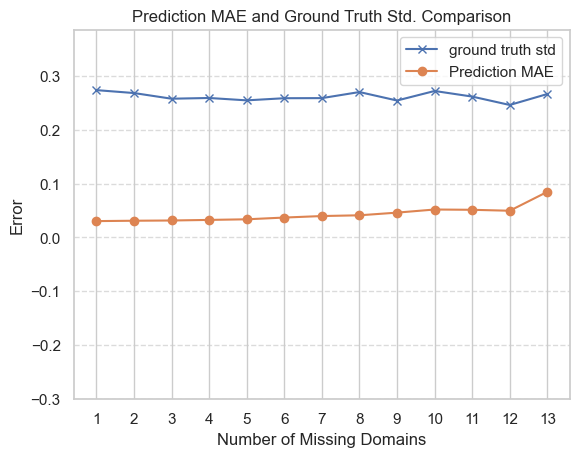

In [56]:
plot_error_by_nan_count_nonzero_only(ground_truth_prediction, ground_truth_test_data_final, metric="mae")  # Use "mse" for Mean Squared Error

## average improvement/score by number of missing domains

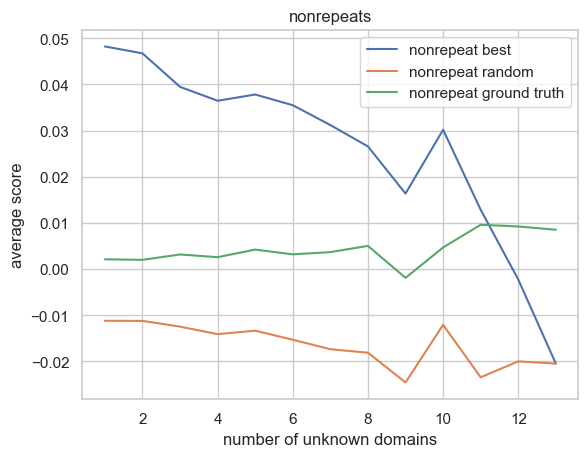

In [57]:
plt.figure()
plt.plot(range(1, 14), nonrepeat_best_avg, label="nonrepeat best")
plt.plot(range(1, 14), nonrepeat_random_avg, label="nonrepeat random")
plt.plot(range(1, 14), nonrepeat_ground_truth_avg, label="nonrepeat ground truth")
plt.xlabel("number of unknown domains")
plt.ylabel("average score")
plt.title("nonrepeats")
plt.legend()
plt.show()

## violin plot for score

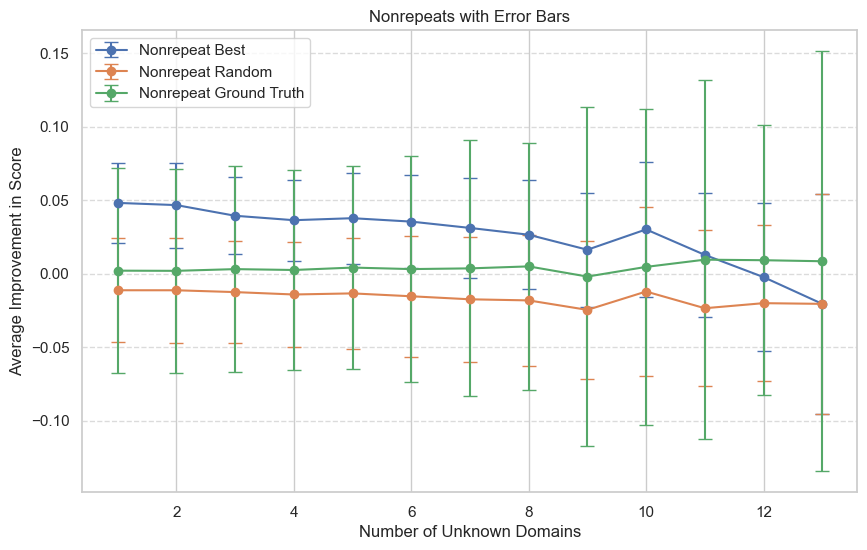

In [58]:
# Define x-axis values (number of unknown domains)
x_values = range(1, 14)

# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(x_values, nonrepeat_best_avg, yerr=nonrepeat_best_std, label="Nonrepeat Best", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_random_avg, yerr=nonrepeat_random_std, label="Nonrepeat Random", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_ground_truth_avg, yerr=nonrepeat_ground_truth_std, label="Nonrepeat Ground Truth", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Nonrepeats with Error Bars")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [59]:
def plot_violin_difference(ground_truth_data_df, random_data_df, best_data_df):
    ## set up variables
    ground_truth_dict = dict()
    random_dict = dict()
    best_dict = dict()

    ## go through data to obtain what's needed for plots
    for n in range(1, 14):
        print("========= %d missing" % n)
        ## set the variables for what we are working with
        print("----ground truth----")
        ground_truth_temp = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
        ground_truth_target_matrix = np.nan_to_num(ground_truth_temp[target_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        ground_truth_current_matrix = np.nan_to_num(ground_truth_temp[score_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        print("current ground truth: ", ground_truth_current_matrix)
        print("target ground truth: ", ground_truth_target_matrix)
        ground_truth_improvement = ground_truth_target_matrix - ground_truth_current_matrix
        ground_truth_dict[str(n)] = ground_truth_improvement
        
        print("----random----")
        random_temp = random_test_data_n[n][random_test_data_n[n].repeat == True]
        random_target_matrix = np.nan_to_num(random_temp[target_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        random_current_matrix = np.nan_to_num(random_temp[score_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        print("current random: ", random_current_matrix)
        print("target random: ", random_target_matrix)
        random_improvement = random_target_matrix - random_current_matrix
        random_dict[str(n)] = random_improvement

        print("----best----")
        best_temp = best_test_data_n[n][best_test_data_n[n].repeat == True]
        best_target_matrix = np.nan_to_num(best_temp[target_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        best_current_matrix = np.nan_to_num(best_temp[score_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        print("current best: ", best_current_matrix)
        print("target best: ", best_target_matrix)
        best_improvement = best_target_matrix - best_current_matrix
        best_dict[str(n)] = best_improvement

        ## assert and print statements for debugging
        # assert ground_truth_temp.shape == random_temp.shape and best_temp.shape == ground_truth_temp.shape, "shapes between don't match"

    ## create plot_df
    plot_df_ground_truth = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)
    plot_df_random = pd.concat(map(pd.Series, random_dict.values()), keys=random_dict.keys(), axis=1)
    plot_df_best = pd.concat(map(pd.Series, best_dict.values()), keys=best_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_ground_truth, ax=axes)
    # sns.violinplot(data=plot_df_random, ax=axes)
    # sns.violinplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Score")
    plt.title(f"Ground Truth Average Score Distribution by Number of Missing domains Violinplot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_random, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Score")
    plt.title(f"Random Average Score Distribution by Number of Missing domains Violinplot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Score")
    plt.title(f"Best Average Score Distribution by Number of Missing domains Violinplot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

========= 1 missing
----ground truth----
current ground truth:  [0.226 0.467 0.722 ... 0.679 0.054 0.662]
target ground truth:  [0.232 0.467 0.722 ... 0.679 0.031 0.662]
----random----
current random:  [0.946 0.174 1.    ... 0.167 0.8   0.084]
target random:  [0.9258156  0.17592785 0.9970069  ... 0.17638214 0.73967093 0.15881027]
----best----
current best:  [0.013 0.757 0.693 ... 0.    0.054 0.084]
target best:  [0.09318559 0.76642632 0.71957445 ... 0.06965914 0.09213179 0.15881027]
========= 2 missing
----ground truth----
current ground truth:  [0.8   0.5   0.    ... 0.56  0.684 0.373]
target ground truth:  [0.8   0.5   0.275 ... 0.56  0.695 0.373]
----random----
current random:  [0.867 0.143 0.    ... 0.424 1.    0.11 ]
target random:  [0.84348655 0.18762265 0.10211837 ... 0.43344802 0.9948987  0.10732479]
----best----
current best:  [0.84  0.    0.    ... 0.8   0.252 0.075]
target best:  [0.89063442 0.0738271  0.10211837 ... 0.87616724 0.33756584 0.1156943 ]
========= 3 missing
----

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_72361/1179274135.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


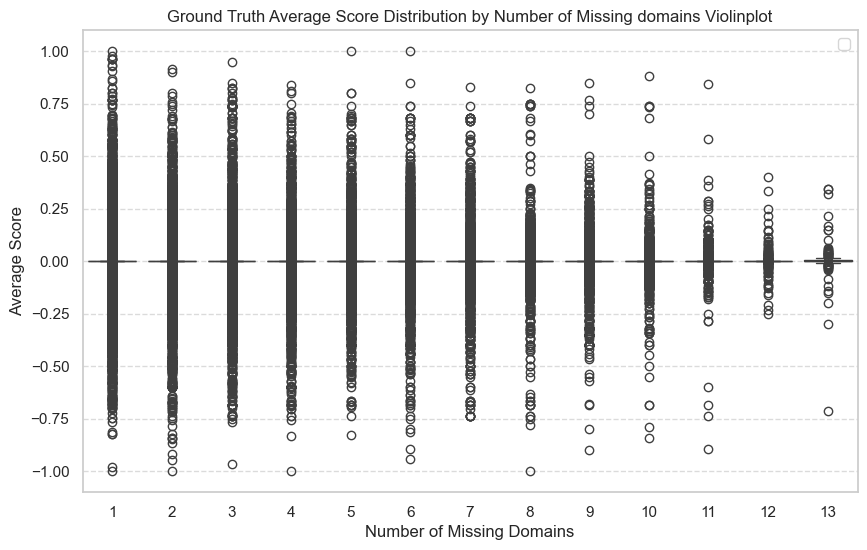

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_72361/1179274135.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


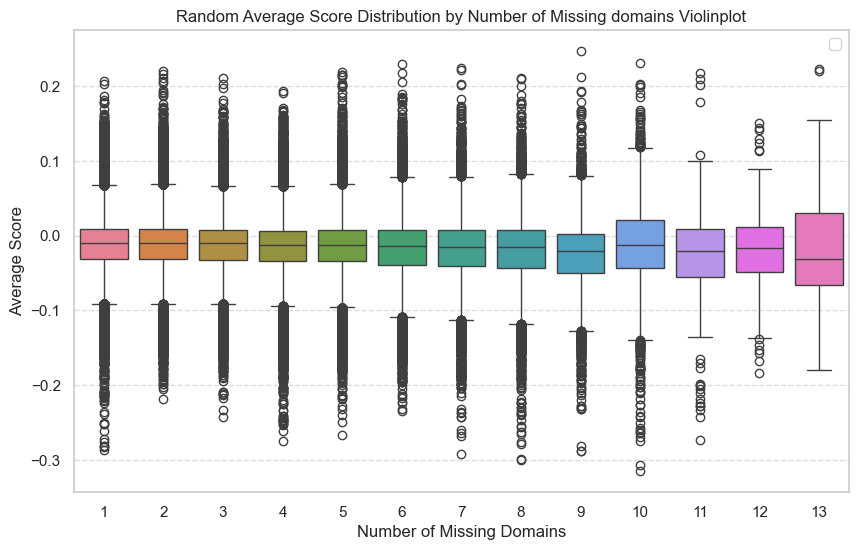

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_72361/1179274135.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


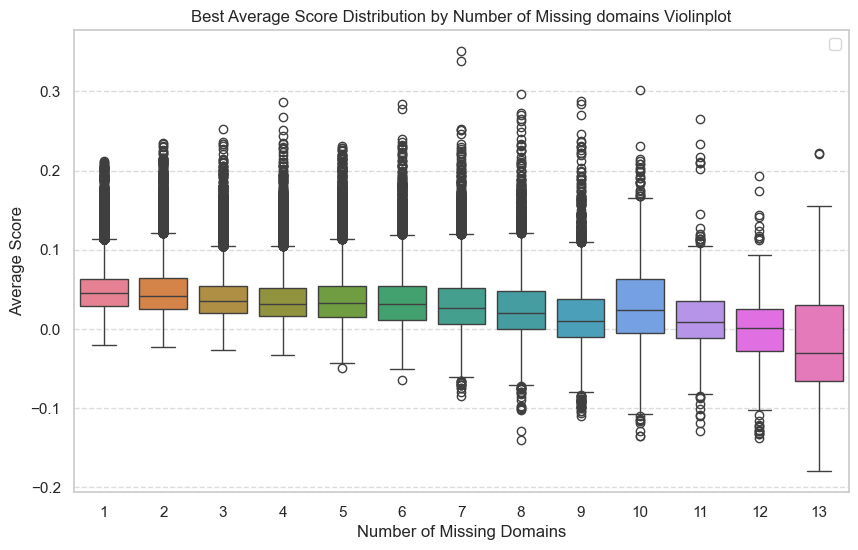

In [60]:
plot_violin_difference(ground_truth_test_data_final, random_test_data_final, best_test_data_final)

# Misc

In [61]:
ids = []

In [62]:
for n in range(1, 14):
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_repeat) != 0:
        ids.append(temp_repeat.index[0])
    if len(temp_nonrepeat) != 0:
        ids.append(temp_nonrepeat.index[0])

In [63]:
ids

[495987,
 2783219,
 2731248,
 2580858,
 232833,
 2996537,
 3556350,
 1982037,
 1160985,
 574039,
 2964764,
 519443,
 3123953]